In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
worldbank_economic_data = pd.read_csv("./data/worldbank_economic_data.csv")
worldbank_inflation_data = pd.read_csv("./data/worldbank_inflation_data.csv")
GSCPI_data = pd.read_csv("./data/GSCPI_data.csv")
LPI_data = pd.read_csv("./data/LPIextend.csv")
df_train = pd.read_csv("./data/train-data.csv", sep=";")
df_test = pd.read_csv("./data/X_test.csv", sep=";")

In [3]:
int_parser = lambda s: "".join(str(s).split())

def fix_strings(df):
    x = df.copy()
    for c in map(lambda i: "Month " + str(i), range(1, 5)):
        if c in x.columns:
            x[c] = x[c].apply(int_parser)
    return x

In [11]:
#df_train = fix_strings(df_train)
#df_test = fix_strings(df_test)

In [4]:
def transform_date(x, month_4 = False):
    # Extraction de l'année
    # Extraction et conversion du mois de début de la plage de dates
    
    dates = []
    values = []
    #for d, v1,v2,v3,v4 in zip(x['Date'],x['Month 1'],x['Month 2'], x['Month 3'], x['Month 4']) :
    for i,d in enumerate(x['Date']) :
        year = d[-4:]
        if 'jan' in d:
            if month_4:
                dates.extend([f'{year}-01', f'{year}-02', f'{year}-03', f'{year}-04'])
            else:
                dates.extend([f'{year}-01', f'{year}-02', f'{year}-03'])
        if 'may' in d:
            if month_4:
                dates.extend([f'{year}-05', f'{year}-06', f'{year}-07', f'{year}-08'])
            else:
                dates.extend([f'{year}-05', f'{year}-06', f'{year}-07'])
        if 'sep' in d:
            if month_4:
                dates.extend([f'{year}-09', f'{year}-10', f'{year}-11', f'{year}-12'])
            else:
                dates.extend([f'{year}-09', f'{year}-10', f'{year}-11'])

        if month_4:
            values.extend([x['Month 1'][i],x['Month 2'][i], x['Month 3'][i], x['Month 4'][i]])
        else:
            values.extend([x['Month 1'][i],x['Month 2'][i], x['Month 3'][i]])

    tmp = sorted(zip(dates, values))
    tmp = np.array(tmp)
    dates = tmp[:,0]
    values = tmp[:,1]

    return dates, values

def concatenate(df_train, df_test):

    # df_train = fix_strings(df_train)
    # df_test = fix_strings(df_test)

    date_features = ['Date','Month 1', 'Month 2', 'Month 3']
    #date_features = ['Date','Month 1', 'Month 2', 'Month 3', 'Month 4']
    #date_features_test = ['Date', 'Month 1', 'Month 2', 'Month 3']

    df_train.drop_duplicates(subset=['index'], keep='first', inplace=True)
    tmp_train = df_train.groupby('id_product')[date_features].agg(lambda x : list(x))

    tmp_test = df_test.groupby('id_product')[date_features].agg(lambda x : list(x))
    #tmp_test = df_test.groupby('id_product')[date_features_test].agg(lambda x : list(x))
    #default_value = None
    #tmp_test['Month 4'] = tmp_test['Date'].apply(lambda x : [default_value for elt in x])

    merged_df = pd.DataFrame()
    for features in date_features:
        merged_df[features] = tmp_train[features].combine(tmp_test[features], lambda x, y: x + y if isinstance(x,list) and isinstance(y,list) else x if isinstance(x,list) else y)

    merged_df = merged_df.apply(lambda x : transform_date(x), axis = 1)
    features = [x[0] for x in merged_df.values]
    values = [x[1]#.astype(float)
              for x in merged_df.values]

    # print(values[0])

    # Creating a DataFrame
    result_df = pd.DataFrame(values, index=merged_df.index, columns=features[0])
    columns_to_drop = ['Month 1', 'Month 2', 'Month 3']

    df_train = df_train.set_index(['id_product']).join(result_df)
    df_train = df_train.drop(columns=columns_to_drop, axis=1)
    df_train = df_train.rename(columns={'Month 4': 'target'})

    df_test = df_test.set_index(['id_product']).join(result_df)
    df_test = df_test.drop(columns=columns_to_drop, axis=1)
    #df_test = df_test.rename(columns={'Month 4': 'target'})

    return df_train, df_test

In [61]:
# df_train[df_train["id_product"] == df_train["id_product"].iloc[250]]

In [62]:
# t[0].reset_index()[t[0].reset_index()["id_product"] == 43696][["index", "2020-09", "2020-10"]]

In [5]:
t = concatenate(df_train, df_test)

In [6]:
train_data = t[0].reset_index()

In [7]:
train_data

,id_product,index,Region,Country,Site,Operations,Zone,Cluster,Reference proxy,Product Line proxy,...,2022-07,2022-09,2022-10,2022-11,2023-01,2023-02,2023-03,2023-05,2023-06,2023-07
0,0,244857,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-1,Product Line-1,...,0,0,0,0,0,0,0,nan,0,0
1,0,979428,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-1,Product Line-1,...,0,0,0,0,0,0,0,nan,0,0
2,0,734571,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-1,Product Line-1,...,0,0,0,0,0,0,0,nan,0,0
3,0,1469142,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-1,Product Line-1,...,0,0,0,0,0,0,0,nan,0,0
4,0,1224285,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-1,Product Line-1,...,0,0,0,0,0,0,0,nan,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762965,244856,244856,CHINA,HK,HK_DC_HongKong,China Operations,China & HK,Hong Kong & Macao,reference-9687,Product Line-4,...,0,0,0,0,0,0,0,nan,0,0
1762966,244856,734570,CHINA,HK,HK_DC_HongKong,China Operations,China & HK,Hong Kong & Macao,reference-9687,Product Line-4,...,0,0,0,0,0,0,0,nan,0,0
1762967,244856,2203712,CHINA,HK,HK_DC_HongKong,China Operations,China & HK,Hong Kong & Macao,reference-9687,Product Line-4,...,0,0,0,0,0,0,0,nan,0,0
1762968,244856,1469141,CHINA,HK,HK_DC_HongKong,China Operations,China & HK,Hong Kong & Macao,reference-9687,Product Line-4,...,0,0,0,0,0,0,0,nan,0,0


In [ ]:
train_data.to_csv("train_data_processed27.csv")

In [17]:
# train_data = pd.read_csv("train_data_processed27.csv")

In [18]:
train_data

,id_product,index,Region,Country,Site,Operations,Zone,Cluster,Reference proxy,Product Line proxy,...,2022-07,2022-09,2022-10,2022-11,2023-01,2023-02,2023-03,2023-05,2023-06,2023-07
0,0,244857,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-1,Product Line-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
1,0,979428,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-1,Product Line-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
2,0,734571,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-1,Product Line-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
3,0,1469142,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-1,Product Line-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
4,0,1224285,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-1,Product Line-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762965,244856,244856,CHINA,HK,HK_DC_HongKong,China Operations,China & HK,Hong Kong & Macao,reference-9687,Product Line-4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
1762966,244856,734570,CHINA,HK,HK_DC_HongKong,China Operations,China & HK,Hong Kong & Macao,reference-9687,Product Line-4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
1762967,244856,2203712,CHINA,HK,HK_DC_HongKong,China Operations,China & HK,Hong Kong & Macao,reference-9687,Product Line-4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
1762968,244856,1469141,CHINA,HK,HK_DC_HongKong,China Operations,China & HK,Hong Kong & Macao,reference-9687,Product Line-4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0


# Add supplementary data - GSCPI data

In [19]:
date_correspondance = {
    '2021-01': 'jan-apr 2021', '2021-02': 'jan-apr 2021', '2021-03': 'jan-apr 2021', '2021-04': 'jan-apr 2021',
    '2021-05': 'may-aug 2021', '2021-06': 'may-aug 2021', '2021-07': 'may-aug 2021', '2021-08': 'may-aug 2021',
    '2021-09': 'sep-dec 2021', '2021-10': 'sep-dec 2021', '2021-11': 'sep-dec 2021', '2021-12': 'sep-dec 2021',
    '2022-01': 'jan-apr 2022', '2022-02': 'jan-apr 2022', '2022-03': 'jan-apr 2022', '2022-04': 'jan-apr 2022',
    '2022-05': 'may-aug 2022', '2022-06': 'may-aug 2022', '2022-07': 'may-aug 2022', '2022-08': 'may-aug 2022',
    '2022-09': 'sep-dec 2022', '2022-10': 'sep-dec 2022', '2022-11': 'sep-dec 2022', '2022-12': 'sep-dec 2022',
    '2023-01': 'jan-apr 2023', '2023-02': 'jan-apr 2023', '2023-03': 'jan-apr 2023', '2023-04': 'jan-apr 2023',
    '2023-05': 'may-jul 2023', '2023-06': 'may-jul 2023', '2023-07': 'may-jul 2023', '2023-08': 'may-jul 2023',
}

In [20]:
GSCPI_data = GSCPI_data[GSCPI_data["Year-Month"].isin(date_correspondance.keys())]

In [21]:
GSCPI_data["Date"] = GSCPI_data["Year-Month"].apply(lambda s: date_correspondance[s])

In [22]:
train_data = train_data.set_index(["Date"]).join(GSCPI_data.dropna().groupby(["Date"])["GSCPI"].mean()).reset_index()

In [23]:
train_data

,Date,id_product,index,Region,Country,Site,Operations,Zone,Cluster,Reference proxy,...,2022-09,2022-10,2022-11,2023-01,2023-02,2023-03,2023-05,2023-06,2023-07,GSCPI
0,jan-apr 2021,0,244857,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-1,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,2.030159
1,jan-apr 2021,1,244858,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-2,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,2.030159
2,jan-apr 2021,3,244860,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-2,...,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,2.030159
3,jan-apr 2021,4,244861,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-2,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,2.030159
4,jan-apr 2021,5,244862,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-2,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,2.030159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762965,sep-dec 2022,244851,1713993,CHINA,CN,CN_DC_Shanghai,China Operations,China & HK,China,reference-22406,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.111621
1762966,sep-dec 2022,244852,1713994,CHINA,CN,CN_DC_Wuhan,China Operations,China & HK,China,reference-22406,...,0.0,0.0,0.0,0.0,0.0,5.0,NaN,0.0,5.0,1.111621
1762967,sep-dec 2022,244853,1713995,CHINA,CN,CN_DC_Wuhan,China Operations,China & HK,China,reference-22406,...,10.0,20.0,50.0,0.0,0.0,70.0,NaN,50.0,120.0,1.111621
1762968,sep-dec 2022,244855,1713997,CHINA,HK,HK_DC_HongKong,China Operations,China & HK,Hong Kong & Macao,reference-9686,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.111621


# Add supplementary data - Worldbank economic data

# Add supplementary data - Worldbank inflation data

In [24]:
def convert_date_range_to_year_month(date_range_str):
    # Extraction de l'année
    year = date_range_str[-4:]
    # Extraction et conversion du mois de début de la plage de dates
    month_str = date_range_str[:3].lower()
    month_conversion = {
        "jan": "01", "feb": "02", "mar": "03", "apr": "04", "may": "05", "jun": "06",
        "jul": "07", "aug": "08", "sep": "09", "oct": "10", "nov": "11", "dec": "12"
    }
    month = month_conversion.get(month_str, '01')  # Par défaut janvier si non trouvé
    # Assemblage de la date au format 'YYYY-MM'
    return f"{year}-{month}"

In [25]:
date_correspondance = {
    '2021-01': 'jan-apr 2021', '2021-02': 'jan-apr 2021', '2021-03': 'jan-apr 2021', '2021-04': 'jan-apr 2021',
    '2021-05': 'may-aug 2021', '2021-06': 'may-aug 2021', '2021-07': 'may-aug 2021', '2021-08': 'may-aug 2021',
    '2021-09': 'sep-dec 2021', '2021-10': 'sep-dec 2021', '2021-11': 'sep-dec 2021', '2021-12': 'sep-dec 2021',
    '2022-01': 'jan-apr 2022', '2022-02': 'jan-apr 2022', '2022-03': 'jan-apr 2022', '2022-04': 'jan-apr 2022',
    '2022-05': 'may-aug 2022', '2022-06': 'may-aug 2022', '2022-07': 'may-aug 2022', '2022-08': 'may-aug 2022',
    '2022-09': 'sep-dec 2022', '2022-10': 'sep-dec 2022', '2022-11': 'sep-dec 2022', '2022-12': 'sep-dec 2022',
    '2023-01': 'jan-apr 2023', '2023-02': 'jan-apr 2023', '2023-03': 'jan-apr 2023', '2023-04': 'jan-apr 2023',
    '2023-05': 'may-jul 2023', '2023-06': 'may-jul 2023', '2023-07': 'may-jul 2023', '2023-08': 'may-jul 2023',
}

In [26]:
# train_data["dt"] = train_data["Date"].apply(lambda dt: convert_date_range_to_year_month(dt))

In [27]:
train_data.loc[train_data["Cluster"] == "USA", "Cluster"] = "United States"
train_data.loc[train_data["Cluster"] == "Hong Kong & Macao", "Cluster"] = "Hong Kong"

In [28]:
worldbank_inflation_data = worldbank_inflation_data[worldbank_inflation_data["Year-Month"].isin(date_correspondance.keys())]

In [29]:
worldbank_inflation_data["Date"] = worldbank_inflation_data["Year-Month"].apply(lambda s: date_correspondance[s])

In [30]:
worldbank_inflation_data.dropna().groupby(["Country", "Date"])["Headline Consumer Price Index"].mean()

Country   Date        
Albania   jan-apr 2021      123.514454
          jan-apr 2022      129.546124
          jan-apr 2023      137.053414
          may-aug 2021      122.778698
          may-aug 2022      131.836366
                              ...     
Zimbabwe  jan-apr 2022     7682.129727
          may-aug 2021     5227.369481
          may-aug 2022    11422.663728
          sep-dec 2021     6315.101395
          sep-dec 2022    14125.011908
Name: Headline Consumer Price Index, Length: 1002, dtype: float64

In [31]:
# edit
# worldbank_inflation_data[worldbank_inflation_data["Country"] == "South East Asia"] = worldbank_inflation_data[worldbank_inflation_data["Country"] == "Japan"]
#                                                                                     + worldbank_inflation_data[worldbank_inflation_data["Country"] == "Korea"]

In [32]:
worldbank_inflation_data[worldbank_inflation_data["Country"] == "South East Asia"]

,Country,Year-Month,Energy Price Index,Headline Consumer Price Index,Date


In [33]:
train_data["Cluster"].unique()

array(['Australia', 'South East Asia', 'North East Asia', 'New Zealand',
       'Pacific Islands', 'United States', 'United Kingdom', 'Denmark',
       'Italy', 'Sweden', 'Spain', 'Germany', 'Middle Eastern Europe',
       'Netherlands', 'Belgium', 'France', 'China', 'Hong Kong'],
      dtype=object)

In [34]:
np.isin(train_data["Cluster"].unique(), worldbank_inflation_data["Country"].unique())

array([False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False])

In [35]:
train_data["Country"] = train_data["Cluster"]

In [36]:
# train_data = train_data.set_index(["Country", "Date"]).join(worldbank_inflation_data.set_index(["Country", "Date"]))
# worldbank_inflation_data = worldbank_inflation_data.set_index(["Country", "Date"])
train_data = train_data.set_index(["Country", "Date"]).join(worldbank_inflation_data.dropna().groupby(["Country", "Date"])["Headline Consumer Price Index", "Energy Price Index"].mean())

/tmp/ipykernel_84104/2412402297.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_data = train_data.set_index(["Country", "Date"]).join(worldbank_inflation_data.dropna().groupby(["Country", "Date"])["Headline Consumer Price Index", "Energy Price Index"].mean())


In [37]:
train_data = train_data.reset_index()

In [38]:
train_data.to_csv("train_data_enriched.csv")

In [39]:
train_data.dropna(subset=["Headline Consumer Price Index"]).groupby(["Country"])["Headline Consumer Price Index"].mean()

Country
Belgium           118.003488
China             130.946093
Denmark           110.496263
France            110.149507
Germany           113.686583
Italy             110.398033
Netherlands       117.094324
Spain             112.498714
Sweden            115.822744
United Kingdom    117.426453
United States     120.030336
Name: Headline Consumer Price Index, dtype: float64

# Data cleaning

Drop duplicates

In [40]:
train_data = train_data.drop_duplicates(["index"])

In [41]:
# train_data = train_data.fillna(-1)

Check distribution of column counts by index

In [42]:
train_data.describe()

,id_product,index,target,2020-09,2020-10,2020-11,2021-01,2021-02,2021-03,2021-05,...,2022-11,2023-01,2023-02,2023-03,2023-05,2023-06,2023-07,GSCPI,Headline Consumer Price Index,Energy Price Index
count,1.762970e+06,1.762970e+06,1.762970e+06,1.762970e+06,1.762970e+06,1.762970e+06,1.762970e+06,1.762970e+06,1.762970e+06,1.762970e+06,...,1.762970e+06,1.762970e+06,1.762970e+06,1.762970e+06,0.0,1.762970e+06,1.762970e+06,1.566698e+06,1.025681e+06,1.025681e+06
mean,1.224159e+05,1.101680e+06,2.679187e+01,3.585721e+01,2.357776e+01,3.203681e+01,3.323086e+01,2.666052e+01,4.469303e+01,4.102567e+01,...,2.287962e+01,1.608698e+01,2.195237e+01,4.351508e+01,NaN,3.026466e+01,3.045465e+01,1.697573e+00,1.172464e+02,1.351894e+02
std,7.068119e+04,6.362992e+05,6.927619e+02,7.560694e+02,5.235503e+02,9.985747e+02,7.835216e+02,6.161842e+02,1.126882e+03,9.422040e+02,...,6.550229e+02,2.422289e+02,4.288995e+02,8.898319e+02,NaN,6.849014e+02,1.326888e+03,1.646366e+00,8.096169e+00,2.779796e+01
min,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,-1.153880e+00,1.036250e+02,9.881835e+01
25%,6.119400e+04,5.507065e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,-4.302773e-01,1.100250e+02,1.103307e+02
50%,1.223860e+05,1.101724e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,2.030159e+00,1.166250e+02,1.333277e+02
75%,1.836208e+05,1.652811e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,2.957795e+00,1.245750e+02,1.513173e+02
max,2.448560e+05,2.203712e+06,2.452200e+05,1.787300e+05,1.317600e+05,1.808650e+05,1.600000e+05,1.300000e+05,1.903200e+05,1.407850e+05,...,2.400000e+05,5.204100e+04,9.000000e+04,1.551960e+05,NaN,1.134690e+05,4.224250e+05,3.897540e+00,1.327633e+02,2.358675e+02


Fixing problematic string types

In [40]:
# train_data["Month 1"] = train_data["Month 1"].apply(lambda s: "".join(str(s).split())).astype("float")
# train_data["Month 2"] = train_data["Month 2"].apply(lambda s: "".join(str(s).split())).astype("float")
# train_data["Month 3"] = train_data["Month 3"].apply(lambda s: "".join(str(s).split())).astype("float")
# train_data["Month 4"] = train_data["Month 4"].apply(lambda s: "".join(str(s).split())).astype("float")

Remove useless columns

In [43]:
train_data.columns

Index(['Country', 'Date', 'id_product', 'index', 'Region', 'Site',
       'Operations', 'Zone', 'Cluster', 'Reference proxy',
       'Product  Line proxy', 'Division proxy', 'Customer Persona proxy',
       'Strategic Product Family proxy', 'Product Life cycel status', 'target',
       '2020-09', '2020-10', '2020-11', '2021-01', '2021-02', '2021-03',
       '2021-05', '2021-06', '2021-07', '2021-09', '2021-10', '2021-11',
       '2022-01', '2022-02', '2022-03', '2022-05', '2022-06', '2022-07',
       '2022-09', '2022-10', '2022-11', '2023-01', '2023-02', '2023-03',
       '2023-05', '2023-06', '2023-07', 'GSCPI',
       'Headline Consumer Price Index', 'Energy Price Index'],
      dtype='object')

In [48]:
train_data

,Country,Date,id_product,index,Region,Site,Operations,Zone,Cluster,Reference proxy,...,2022-11,2023-01,2023-02,2023-03,2023-05,2023-06,2023-07,GSCPI,Headline Consumer Price Index,Energy Price Index
0,Australia,jan-apr 2021,0,244857,EAJP,AU_DC_Sydney,International Operations,Pacific,Australia,reference-1,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,2.030159,NaN,NaN
1,Australia,jan-apr 2021,1,244858,EAJP,AU_DC_Sydney,International Operations,Pacific,Australia,reference-2,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,2.030159,NaN,NaN
2,Australia,jan-apr 2021,3,244860,EAJP,AU_DC_Sydney,International Operations,Pacific,Australia,reference-2,...,1.0,0.0,0.0,0.0,NaN,0.0,0.0,2.030159,NaN,NaN
3,Australia,jan-apr 2021,4,244861,EAJP,AU_DC_Sydney,International Operations,Pacific,Australia,reference-2,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,2.030159,NaN,NaN
4,Australia,jan-apr 2021,5,244862,EAJP,AU_DC_Sydney,International Operations,Pacific,Australia,reference-2,...,0.0,1.0,0.0,0.0,NaN,0.0,0.0,2.030159,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762965,United States,sep-dec 2022,93566,1562708,NAM,US_DC_PED,North America Operations,US,United States,reference-10461,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.111621,125.4305,143.62025
1762966,United States,sep-dec 2022,93568,1562710,NAM,US_DC_PED,North America Operations,US,United States,reference-10461,...,0.0,0.0,46.0,0.0,NaN,0.0,0.0,1.111621,125.4305,143.62025
1762967,United States,sep-dec 2022,93569,1562711,NAM,US_DC_PED,North America Operations,US,United States,reference-10461,...,0.0,0.0,1.0,0.0,NaN,1.0,1.0,1.111621,125.4305,143.62025
1762968,United States,sep-dec 2022,93570,1562712,NAM,US_DC_PED,North America Operations,US,United States,reference-10461,...,1.0,0.0,0.0,0.0,NaN,0.0,0.0,1.111621,125.4305,143.62025


In [ ]:
train_data = train_data.drop(["Region", "Country", "Zone", "Cluster", "Reference proxy"], axis=1)

Set categorical variables

In [43]:
# train_data = pd.get_dummies(train_data)

Remove outliers

In [44]:
# train_data[train_data["Month 1"] == np.infty]

In [45]:
# plt.hist(train_data[train_data["Month 1"] < 500]["Month 1"].values)

In [46]:
# plt.hist(train_data["Headline Consumer Price Index"].values)

In [47]:
# plt.hist(train_data["Energy Price Index"].values)

In [48]:
# sns.histplot(data=train_data, x="Month 1")

In [49]:
# num_cols = ["Month 1", "Month 2", "Month 3", "Month 4", "Headline Consumer Price Index", "Energy Price Index", "GSCPI"]

In [50]:
num_cols = ['target', '2020-09', '2020-10', '2020-11', '2021-01', '2021-02',
            '2021-03', '2021-05', '2021-06', '2021-07', '2021-09', '2021-10',
            '2021-11', '2022-01', '2022-02', '2022-03', '2022-05', '2022-06',
            '2022-07', '2022-09', '2022-10', '2022-11', '2023-01', '2023-02',
            '2023-03', '2023-05', '2023-06', '2023-07']

In [51]:
# train_data[num_cols].corr()

In [52]:
# train_data[num_cols] > -1

Replace Nans by -1

In [53]:
# train_data = train_data.fillna(-1)

Set date ordinal

In [55]:
# train_data["Date"]

In [47]:
train_data

,Country,Date,id_product,index,Region,Site,Operations,Zone,Cluster,Reference proxy,...,2022-11,2023-01,2023-02,2023-03,2023-05,2023-06,2023-07,GSCPI,Headline Consumer Price Index,Energy Price Index
0,Australia,jan-apr 2021,0,244857,EAJP,AU_DC_Sydney,International Operations,Pacific,Australia,reference-1,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,2.030159,NaN,NaN
1,Australia,jan-apr 2021,1,244858,EAJP,AU_DC_Sydney,International Operations,Pacific,Australia,reference-2,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,2.030159,NaN,NaN
2,Australia,jan-apr 2021,3,244860,EAJP,AU_DC_Sydney,International Operations,Pacific,Australia,reference-2,...,1.0,0.0,0.0,0.0,NaN,0.0,0.0,2.030159,NaN,NaN
3,Australia,jan-apr 2021,4,244861,EAJP,AU_DC_Sydney,International Operations,Pacific,Australia,reference-2,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,2.030159,NaN,NaN
4,Australia,jan-apr 2021,5,244862,EAJP,AU_DC_Sydney,International Operations,Pacific,Australia,reference-2,...,0.0,1.0,0.0,0.0,NaN,0.0,0.0,2.030159,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762965,United States,sep-dec 2022,93566,1562708,NAM,US_DC_PED,North America Operations,US,United States,reference-10461,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.111621,125.4305,143.62025
1762966,United States,sep-dec 2022,93568,1562710,NAM,US_DC_PED,North America Operations,US,United States,reference-10461,...,0.0,0.0,46.0,0.0,NaN,0.0,0.0,1.111621,125.4305,143.62025
1762967,United States,sep-dec 2022,93569,1562711,NAM,US_DC_PED,North America Operations,US,United States,reference-10461,...,0.0,0.0,1.0,0.0,NaN,1.0,1.0,1.111621,125.4305,143.62025
1762968,United States,sep-dec 2022,93570,1562712,NAM,US_DC_PED,North America Operations,US,United States,reference-10461,...,1.0,0.0,0.0,0.0,NaN,0.0,0.0,1.111621,125.4305,143.62025


In [49]:
train_data.columns

Index(['Country', 'Date', 'id_product', 'index', 'Region', 'Site',
       'Operations', 'Zone', 'Cluster', 'Reference proxy',
       'Product  Line proxy', 'Division proxy', 'Customer Persona proxy',
       'Strategic Product Family proxy', 'Product Life cycel status', 'target',
       '2020-09', '2020-10', '2020-11', '2021-01', '2021-02', '2021-03',
       '2021-05', '2021-06', '2021-07', '2021-09', '2021-10', '2021-11',
       '2022-01', '2022-02', '2022-03', '2022-05', '2022-06', '2022-07',
       '2022-09', '2022-10', '2022-11', '2023-01', '2023-02', '2023-03',
       '2023-05', '2023-06', '2023-07', 'GSCPI',
       'Headline Consumer Price Index', 'Energy Price Index'],
      dtype='object')

In [45]:
train_data.to_csv("train_data_final.csv")

In [8]:
train_data = pd.read_csv("train_data_final.csv")

: 

# Train-test split / standardization

In [ ]:
normal_columns = ['2020-09', '2020-10', '2020-11',
       '2021-01', '2021-02', '2021-03', '2021-05', '2021-06', '2021-07',
       '2021-09', '2021-10', '2021-11', '2022-01', '2022-02', '2022-03',
       '2022-05', '2022-06', '2022-07', '2022-09', '2022-10', '2022-11',
       '2023-01', '2023-02', '2023-03', '2023-05', '2023-06', '2023-07']

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(train_data.drop("target", axis=1),
                                                    train_data["target"],
                                                    random_state=42, test_size=0.1)

In [ ]:
# Standardize the data
# normal_columns = ["Month 1", "Month 2", "Month 3"]
mu, sigma = X_train[normal_columns].mean(axis=0), X_train[normal_columns].std(axis=0)
X_train.loc[:, normal_columns] = (X_train[normal_columns] - mu) / sigma
X_eval.loc[:, normal_columns] = (X_eval[normal_columns] - mu) / sigma

In [ ]:
# >pd.get_dummies(train_data["Country"])

In [ ]:
# train_data["Date"]

# 

# Model 0 - linear regression - numerical columns

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
reg = LinearRegression().fit(X_train[normal_columns], y_train)

SyntaxError: incomplete input (3011768340.py, line 1)

In [ ]:
pred = reg.predict(X_eval[normal_columns])

In [ ]:
np.mean((y_eval - pred) ** 2)

213466.26776341675

# Model 1 - taking only numerical columns

In [1]:
cols = ['2020-09', '2020-10', '2020-11',
       '2021-01', '2021-02', '2021-03', '2021-05', '2021-06', '2021-07',
       '2021-09', '2021-10', '2021-11', '2022-01', '2022-02', '2022-03',
       '2022-05', '2022-06', '2022-07', '2022-09', '2022-10', '2022-11',
       '2023-01', '2023-02', '2023-03', '2023-05', '2023-06', '2023-07',
       'Date_jan-apr 2021', 'Date_jan-apr 2022',
       'Date_jan-apr 2023', 'Date_may-aug 2021', 'Date_may-aug 2022',
       'Date_may-jul 2023', 'Date_sep-dec 2020', 'Date_sep-dec 2021',
       'Date_sep-dec 2022']

In [ ]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Dense(50, activation='relu'),
#   tf.keras.layers.Dense(50, activation='relu'),
#   tf.keras.layers.Dense(50, activation='relu'),
#   tf.keras.layers.Dense(1),
# ])

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
])

In [ ]:
model.compile(optimizer="adam", loss='mse')

In [ ]:
X_train[cols]

,2020-09,2020-10,2020-11,2021-01,2021-02,2021-03,2021-05,2021-06,2021-07,2021-09,...,2023-07,Date_jan-apr 2021,Date_jan-apr 2022,Date_jan-apr 2023,Date_may-aug 2021,Date_may-aug 2022,Date_may-jul 2023,Date_sep-dec 2020,Date_sep-dec 2021,Date_sep-dec 2022
464171,-0.047296,-0.044558,-0.031707,-0.042253,-0.043454,-0.039707,-0.030769,-0.048015,-0.031171,-0.043766,...,-0.023084,0,0,1,0,0,0,0,0,0
1057490,-0.047296,-0.042672,-0.031707,-0.042253,-0.043454,-0.039707,-0.043543,-0.046925,-0.031171,-0.043766,...,-0.023084,0,0,0,0,0,1,0,0,0
1593432,0.041205,-0.044558,0.010448,0.006083,-0.043454,0.080100,-0.023317,-0.027315,-0.027355,0.078680,...,-0.023084,0,0,0,0,0,0,0,0,1
1710138,-0.047296,-0.044558,-0.031707,-0.042253,-0.043454,-0.039707,-0.043543,-0.048015,-0.031171,-0.043766,...,-0.023084,0,0,0,0,0,0,0,0,1
624853,-0.047296,-0.037011,-0.031707,-0.042253,-0.043454,-0.029058,-0.043543,-0.048015,-0.031171,-0.043766,...,-0.023084,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,0.348980,4.332767,0.115346,2.107435,-0.043454,0.909874,-0.043543,1.008786,1.275951,0.491195,...,2.022397,0,1,0,0,0,0,0,0,0
1414414,-0.047296,-0.044558,-0.031707,-0.042253,-0.043454,-0.039707,-0.000961,-0.048015,-0.031171,-0.043766,...,-0.023084,0,0,0,0,0,0,0,1,0
131932,-0.047296,-0.044558,-0.031707,-0.042253,-0.043454,-0.039707,-0.043543,-0.045836,-0.031171,-0.043766,...,-0.023084,1,0,0,0,0,0,0,0,0
671155,-0.047296,-0.044558,-0.031707,-0.042253,-0.043454,-0.039707,-0.043543,-0.048015,-0.031171,-0.043766,...,-0.023084,0,0,0,1,0,0,0,0,0


In [ ]:
y_eval

486200      0.0
355078      1.0
1607054     0.0
1064076     0.0
590750      8.0
           ... 
1677782     0.0
69158      11.0
1472229     0.0
1439781     0.0
381117      0.0
Name: target, Length: 176297, dtype: float64

In [ ]:
history = model.fit(X_train[cols].values.astype(np.float32), y_train.values.astype(np.float32), epochs=100, batch_size=1024,
         validation_data=(X_eval[cols].values.astype(np.float32), y_eval.values.astype(np.float32)), shuffle=True)


Epoch 1/100
1550/1550 [==============================] - 2s 881us/step - loss: 499203.5312 - val_loss: 313188.2812
Epoch 2/100
1550/1550 [==============================] - 1s 710us/step - loss: 499143.3750 - val_loss: 313134.2500
Epoch 3/100
1550/1550 [==============================] - 1s 763us/step - loss: 499087.8750 - val_loss: 313083.7188
Epoch 4/100
1550/1550 [==============================] - 1s 743us/step - loss: 499034.3438 - val_loss: 313035.3125
Epoch 5/100
1550/1550 [==============================] - 1s 739us/step - loss: 498984.8438 - val_loss: 312991.3125
Epoch 6/100
1550/1550 [==============================] - 1s 814us/step - loss: 498940.1250 - val_loss: 312951.0312
Epoch 7/100
1550/1550 [==============================] - 1s 780us/step - loss: 498898.5312 - val_loss: 312914.6562
Epoch 8/100
1550/1550 [==============================] - 1s 746us/step - loss: 498859.9688 - val_loss: 312880.1875
Epoch 9/100
1550/1550 [==============================] - 1s 778us/step - loss: 4

KeyboardInterrupt: 

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                370       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


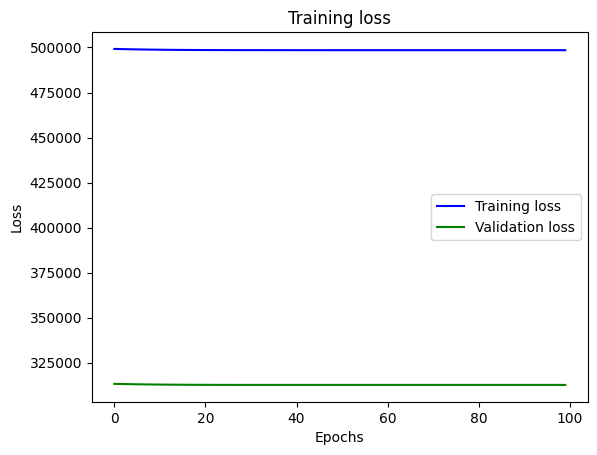

In [ ]:
plt.plot(history.epoch, history.history["loss"], 'b', label='Training loss')
plt.plot(history.epoch, history.history["val_loss"], 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model 1.2 - saturating training

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1000, activation='relu'),
  tf.keras.layers.Dense(1),
])

2023-12-02 15:47:18.030486: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-02 15:47:18.030559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (danilo-Nitro-AN515-58): /proc/driver/nvidia/version does not exist
2023-12-02 15:47:18.032279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model.compile(optimizer="adam", loss='mse')

In [ ]:
history = model.fit(X_train[normal_columns].values.astype(np.float32), y_train.values.astype(np.float32), epochs=100, batch_size=1024,
         validation_data=(X_eval[normal_columns].values.astype(np.float32), y_eval.values.astype(np.float32)), shuffle=True)

NameError: name 'X_train' is not defined

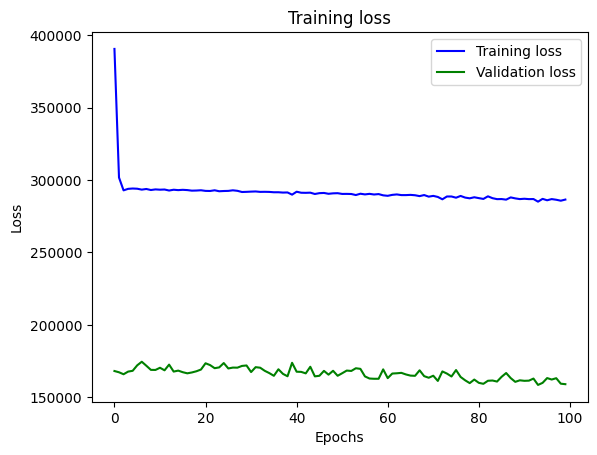

In [ ]:
plt.plot(history.epoch, history.history["loss"], 'b', label='Training loss')
plt.plot(history.epoch, history.history["val_loss"], 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model 2 - including categorical columns

Setting regularization

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  # tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(1),
])

In [ ]:
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(learning_rate=1e-2, weight_decay=1e-6)
model.compile(optimizer=optimizer, loss='mse')

In [ ]:
X_train

,index,id_product,Month 1,Month 2,Month 3,Headline Consumer Price Index,Energy Price Index,Date_jan-apr 2021,Date_jan-apr 2022,Date_jan-apr 2023,...,Strategic Product Family proxy_Strategic Product Family-4,Strategic Product Family proxy_Strategic Product Family-5,Strategic Product Family proxy_Strategic Product Family-6,Strategic Product Family proxy_Strategic Product Family-7,Strategic Product Family proxy_Strategic Product Family-8,Strategic Product Family proxy_Strategic Product Family-9,Product Life cycel status_-1,Product Life cycel status_EOL,Product Life cycel status_NPI,Product Life cycel status_RaMPDOWN
833332,962765,228194,-0.038351,-0.040269,-0.030860,129.79352,103.70250,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1898709,412982,168125,-0.038351,-0.040269,-0.030860,108.62500,108.65500,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2857459,1276899,52614,-0.030341,-0.029095,-0.030002,124.57500,158.75900,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3062075,788110,53539,-0.038351,-0.040269,-0.030860,116.82500,125.54175,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1123572,1436376,212091,0.049756,0.005825,-0.006832,112.62500,151.46750,0,0,0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453461,1485493,16351,-0.038351,-0.040269,-0.030002,-1.00000,-1.00000,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2544707,835463,100892,-0.038351,-0.040269,-0.026569,113.65000,123.95000,0,0,0,...,0,0,0,0,0,1,1,0,0,0
225442,1246658,22373,-0.038351,-0.040269,-0.030860,-1.00000,-1.00000,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1199725,212064,212064,2.631538,-0.029095,1.427990,-1.00000,-1.00000,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [ ]:
history = model.fit(X_train[normal_columns].values.astype(np.float32), y_train.values.astype(np.float32), epochs=100, batch_size=1024,
         validation_data=(X_eval[normal_columns].values.astype(np.float32), y_eval.values.astype(np.float32)), shuffle=True)

Epoch 1/100
1550/1550 [==============================] - 4s 3ms/step - loss: 293465.8750 - val_loss: 225923.9219
Epoch 2/100
1550/1550 [==============================] - 4s 3ms/step - loss: 290017.3125 - val_loss: 341917.7500
Epoch 3/100
1550/1550 [==============================] - 6s 4ms/step - loss: 292195.4062 - val_loss: 580594.6250
Epoch 4/100
1550/1550 [==============================] - 6s 4ms/step - loss: 304355.3125 - val_loss: 214612.6250
Epoch 5/100
1550/1550 [==============================] - 6s 4ms/step - loss: 292424.1250 - val_loss: 220947.5312
Epoch 6/100
1550/1550 [==============================] - 4s 3ms/step - loss: 293792.6875 - val_loss: 241490.2656
Epoch 7/100
1550/1550 [==============================] - 5s 3ms/step - loss: 295569.2188 - val_loss: 218266.2188
Epoch 8/100
1550/1550 [==============================] - 6s 4ms/step - loss: 288225.4375 - val_loss: 228446.0156
Epoch 9/100
1550/1550 [==============================] - 5s 4ms/step - loss: 297941.4375 - val_l

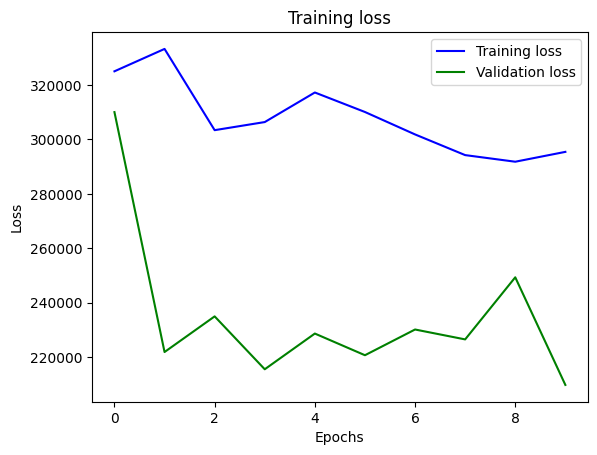

In [ ]:
plt.plot(history.epoch, history.history["loss"], 'b', label='Training loss')
plt.plot(history.epoch, history.history["val_loss"], 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_eval.var()

406520.7450788635

# Model 3 - concatenating multiple dates